In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Requirements

In [ ]:
!pip install antspyx
!pip install pyrobex

In [ ]:
!pip install nilearn

In [ ]:
from pyrobex.robex import robex_stripped
from nilearn import plotting
import ants

In [ ]:
import os
import nibabel as nib
import numpy as np
from PIL import Image
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from natsort import natsorted
import kagglehub
import tarfile
import torch
from torchvision.models import resnet34
import torchvision.models as models
import glob
from torch.utils.data import Dataset
import torchvision.transforms as T

# Downloading Data

In [ ]:
!wget -c http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI-T1.tar

# 2. Extract its contents into a folder called “IXI-T1”
import tarfile

tar_path = 'IXI-T1.tar'
extract_dir = 'IXI-T1'

with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_dir)

In [ ]:
dest = kagglehub.dataset_download("dschettler8845/brats-2021-task1",
                                  path="BraTS2021_Training_Data.tar")


In [ ]:
with tarfile.open(dest, "r") as tar:
    tar.extractall(path="/content/BraTS2021_Training_Data")

In [ ]:
!find /content/BraTS2021_Training_Data -type f ! \( -name '*_t1.nii.gz' -o -name '*_seg.nii.gz' \) -delete

In [ ]:
!find /content/BraTS2021_Training_Data -type f \( -name '*_t1.nii.gz' -o -name '*_seg.nii.gz' \) -exec mv {} /content/BraTS2021_Training_Data/ \;

!find /content/BraTS2021_Training_Data -mindepth 1 -type d -exec rm -rf {} +


In [ ]:
!du -sh /content/IXI-T1

In [ ]:
!mv /content/BraTS2021_Training_Data /content/drive/MyDrive/CV_Proj_Anomaly_AE/

In [ ]:
!mv /content/IXI-T1 /content/drive/MyDrive/CV_Proj_Anomaly_AE/

In [ ]:
# list, sort, then delete everything after the first 150
!find /content/drive/MyDrive/CV_Proj_Anomaly_AE/BraTS2021_Training_Data -maxdepth 1 -type f -name '*_t1.nii.gz' | sort | tail -n +151 | xargs rm -f


# Data Pre-Processing

## Brain Extraction IXI

In [ ]:
img = nib.load("/content/drive/MyDrive/CV_Proj_Anomaly_AE/IXI-T1/IXI002-Guys-0828-T1.nii.gz")
plotting.plot_img(img, cmap='gray')

In [ ]:
from natsort import natsorted

In [ ]:
from concurrent.futures import ProcessPoolExecutor

INPUT_DIR = '/content/drive/MyDrive/CV_Proj_Anomaly_AE/IXI-T1'
NUM_WORKERS = 2
def process_file(fname: str):
    """
    Load a NIfTI file, perform ROBEX skull-stripping, save the brain image,
    and remove the original file.
    """
    fullpath = os.path.join(INPUT_DIR, fname)
    img = nib.load(fullpath)
    brain = robex_stripped(img)

    if fname.endswith('.nii.gz'):
        out_fname = fname.replace('.nii.gz', '_brain.nii.gz')
    else:
        out_fname = fname.replace('.nii', '_brain.nii')
    out_path = os.path.join(INPUT_DIR, out_fname)

    nib.save(brain, out_path)
    os.remove(fullpath)
    return out_fname

def main():
    all_files = natsorted([
        f for f in os.listdir(INPUT_DIR)
        if (f.endswith('.nii') or f.endswith('.nii.gz'))
           and not (f.endswith('_brain.nii')
           or f.endswith('_brain.nii.gz'))
    ])

    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for out_fname in executor.map(process_file, all_files):
            pass

    print("Done")

if __name__ == "__main__":
    main()


## Normalization And Slicing

In [ ]:
resized = ants.resample_image_to_target(volume, reference)

In [ ]:


def resize_volume_to_256(volume):
    """
    Resample a 3D ANTs image so that each axial slice is 256×256 pixels,
    preserving the original number of slices (Z dimension).
    """
    orig_size = volume.shape  # (X, Y, Z)
    new_size = (256, 256, 155)
    # use_voxels=True so new_size is in voxels, interp_type=1 = linear interp
    resized = ants.resample_image(volume, new_size, use_voxels=True, interp_type=1)
    return resized

def extract_axial_slices(volume, ixi=False):
    """
    Extract all axial (XY) slices from a 3D ANTs image as numpy arrays.
    """
    arr = volume.numpy()  # shape (X, Y, Z)
    if ixi:
      slices = [arr[:, k, :] for k in range(arr.shape[1])]
    else:
      slices = [arr[:, :, k] for k in range(arr.shape[2])]
    return slices

def normalize_zero_mean_unit_var(slice_array: np.ndarray) -> np.ndarray:
    """
    Intensity-normalize a 2D slice to zero mean and unit variance.
    """
    mean = slice_array.mean()
    std = slice_array.std()
    if std < 1e-6:
        return slice_array - mean
    return (slice_array - mean) / std

def save_slices_as_png(slices: list[np.ndarray],
                       indices: range,
                       output_dir: str,
                       base_name: str):
    """
    Save selected normalized slices as PNG files in output_dir/base_name/.
    Filenames: {base_name}_slice{idx:03d}.png
    """
    # create the folder for this volume
    save_folder = os.path.join(output_dir, base_name)
    os.makedirs(save_folder, exist_ok=True)

    for idx in indices:
        if idx < 0 or idx >= len(slices):
            continue
        slice_norm = slices[idx]
        # normalize to [0,255] for PNG
        # first clamp to a few stds to avoid outliers
        slice_clamped = np.clip(slice_norm, -5, 5)
        slice_01 = (slice_clamped - slice_clamped.min()) / (slice_clamped.max() - slice_clamped.min())
        slice_uint8 = (slice_01 * 255).astype(np.uint8)

        img = Image.fromarray(slice_uint8)
        fname = f"{base_name}_slice{idx:03d}.png"
        img.save(os.path.join(save_folder, fname))

def process_and_save(path_list: list[str],
                     input_dir: str,
                     output_dir: str,
                     slice_start: int = 75,
                     slice_end: int = 85,
                     ixi=False):
    """
    For each NIfTI file in path_list:
      1. Read and resize to 256×256
      2. Extract axial slices
      3. Normalize zero-mean/unit-var
      4. Save slices [slice_start..slice_end] as PNGs under output_dir/<basename>/
    """

    for fname in path_list:
        full_path = os.path.join(input_dir, fname)
        base = fname.split(".")[0]

        vol = ants.image_read(full_path)
        vol256 = resize_volume_to_256(vol)
        raw_slices = extract_axial_slices(vol256, ixi=ixi)
        norm_slices = [normalize_zero_mean_unit_var(s) for s in raw_slices]

        save_slices_as_png(
            slices=norm_slices,
            indices=range(slice_start, slice_end + 1),
            output_dir=output_dir,
            base_name=base
        )

# directory containing your Brats-21 volumes
brats_dir = "/content/BraTS2021_Training_Data"
brats_files = natsorted(os.listdir(brats_dir))[:400]

# directory containing your IXI volumes
ixi_dir = "/content/drive/MyDrive/CV_Proj_Anomaly_AE/IXI-T1"
ixi_files = os.listdir(ixi_dir)

# where to store the output PNGs
output_root1 = "/content/drive/MyDrive/CV_Proj_Anomaly_AE/brats_slices"
output_root2 = "/content/drive/MyDrive/CV_Proj_Anomaly_AE/ixi_slices"

# Process Brats-21
process_and_save(
    path_list=brats_files,
    input_dir=brats_dir,
    output_dir=output_root1,
    ixi=False,
    slice_start=75,
    slice_end=77
)

# Process IXI
process_and_save(
    path_list=ixi_files,
    input_dir=ixi_dir,
    output_dir=output_root2,
    slice_start=150,
    slice_end=170,
    ixi=True
)


In [ ]:
import shutil
shutil.rmtree("/content/drive/MyDrive/CV_Proj_Anomaly_AE/brats_slices")

In [ ]:
len(os.listdir("/content/drive/MyDrive/CV_Proj_Anomaly_AE/brats_slices"))

In [ ]:


main_folder = '/content/drive/MyDrive/CV_Proj_Anomaly_AE/ixi_slices'

image_extensions = {'.jpg', '.jpeg', '.png'}

for root, dirs, files in os.walk(main_folder, topdown=False):
    if root == main_folder:
        continue
    for file in files:
        file_path = os.path.join(root, file)
        if os.path.splitext(file)[1].lower() in image_extensions:
            shutil.move(file_path, os.path.join(main_folder, file))

    if not os.listdir(root):
        os.rmdir(root)

print("Images moved and subfolders deleted.")


# Model

## Hetro_AE

### 1

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base = models.resnet34(pretrained=pretrained)
        # stem + 4 stages
        self.stem   = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.stage1 = base.layer1    # 64 channels
        self.stage2 = base.layer2    # 128 channels
        self.stage3 = base.layer3    # 256 channels
        self.stage4 = base.layer4    # 512 channels

    def forward(self, x):
        x = self.stem(x)
        f1 = self.stage1(x)
        f2 = self.stage2(f1)
        f3 = self.stage3(f2)
        f4 = self.stage4(f3)
        return [f1, f2, f3, f4]


class MSTB(nn.Module):
    """
    Multi-Scale Sparse Transformer Block that does cross-attention
    from full-map queries onto two patch‐based region key/value sets.
    """
    def __init__(self, in_channels, embed_dim, num_heads, patch_size2, mlp_ratio=4, dropout=0.3):
        super().__init__()
        # two region scales: p1 = p2/2, p2 given
        p1 = patch_size2 // 2

        # project input to embed_dim for queries
        self.local_proj   = nn.Conv2d(in_channels, embed_dim, kernel_size=1)
        # two patch‐based key/value projections
        self.patch_proj1  = nn.Conv2d(in_channels, embed_dim, kernel_size=p1,  stride=p1)
        self.patch_proj2  = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size2, stride=patch_size2)

        # cross‐attention modules (batch_first)
        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # fusion & MLP
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape

        # 1) Full‐map “local” queries
        q = self.local_proj(x).flatten(2).transpose(1,2)
        # shape (B, H*W, embed_dim)

        # 2) Two region scales for keys/values
        k1v1 = self.patch_proj1(x).flatten(2).transpose(1,2)  # (B, N1, embed_dim)
        k2v2 = self.patch_proj2(x).flatten(2).transpose(1,2)  # (B, N2, embed_dim)

        # 3) Cross‐attention per scale
        out1, _ = self.attn1(q, k1v1, k1v1)
        out2, _ = self.attn2(q, k2v2, k2v2)
        attn_out = (out1 + out2) * 0.5

        # 4) Add & Norm
        x1 = self.norm1(q + attn_out)
        x2 = self.norm2(x1 + self.mlp(x1))

        # 5) Back to spatial
        x_spatial = x2.transpose(1,2).reshape(B, -1, H, W)
        return x_spatial


class HybridBlock(nn.Module):
    """
    One decoder stage:
      • 1×1 → split into CNN vs Transformer branches
      • CNN branch: two 3×3 convs
      • Trans branch: MSTB
      • Fuse with 1×1 conv
      • Bilinear upsample ×2
    """
    def __init__(self, in_ch, embed_dim, num_heads, patch_size2):
        super().__init__()
        mid = embed_dim

        self.conv1x1_cnn   = nn.Conv2d(in_ch, mid, kernel_size=1)
        self.conv1x1_trans = nn.Conv2d(in_ch, mid, kernel_size=1)

        self.conv_branch = nn.Sequential(
            nn.Conv2d(mid, mid, 3, padding=1),
            nn.Dropout2d(0.3),
            nn.Conv2d(mid, mid, 3, padding=1),
            nn.Dropout2d(0.3),
        )

        self.trans_branch = MSTB(
            in_channels=mid,
            embed_dim=mid,
            num_heads=num_heads,
            patch_size2=patch_size2
        )

        # paper uses only 1×1 fuse
        self.fuse     = nn.Conv2d(mid * 2, mid, kernel_size=1)
        self.upsample = lambda x: F.interpolate(
            x, scale_factor=2, mode='bilinear', align_corners=False
        )

    def forward(self, x):
        c = self.conv_branch(self.conv1x1_cnn(x))
        t = self.trans_branch(self.conv1x1_trans(x))
        # match spatial dims
        t = F.interpolate(t, size=c.shape[-2:], mode='bilinear', align_corners=False)
        f = self.fuse(torch.cat([c, t], dim=1))
        return self.upsample(f)


class CNNTransformerDecoder(nn.Module):
    def __init__(self, feat_dims=[512, 256, 128, 64]):
        super().__init__()
        # correspond to encoder’s stage dims [512→256→128→64]
        embed_dims = [256, 128, 64]
        num_heads  = [  2,   4,   8]
        p2_sizes   = [  8,   4,   2]

        self.blocks = nn.ModuleList([
            HybridBlock(
                in_ch     = feat_dims[i],
                embed_dim = embed_dims[i],
                num_heads = num_heads[i],
                patch_size2 = p2_sizes[i]
            )
            for i in range(len(embed_dims))
        ])

        # project back to 3‐channel image space
        self.final_conv = nn.Conv2d(embed_dims[-1], 3, kernel_size=3, padding=1)

        # Add a learnable upsampling layer
        self.learnable_upsample = nn.ConvTranspose2d(
            in_channels=3,
            out_channels=3,
            kernel_size=4,
            stride=2,
            padding=1
        )

    def forward(self, feats):
        x = feats[-1]   # deepest encoder feature (512-ch)
        dec_feats = []
        for block in self.blocks:
            x = block(x)
            dec_feats.append(x)

        # reconstruct RGB
        x = self.final_conv(x)

        # Now apply the learnable upsampling
        x = self.learnable_upsample(x)

        self.last_feats = dec_feats
        return x


class HeteroAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNTransformerDecoder()

    def forward(self, x):
        enc_feats = self.encoder(x)
        recon     = self.decoder(enc_feats)
        dec_feats = self.decoder.last_feats
        # return:
        #  • recon: reconstructed image
        #  • enc_feats[:-1]: the three intermediate maps
        #  • dec_feats    : three decoder feature maps
        return recon, enc_feats[:-1], dec_feats


def combined_loss(recon, x, enc_feats, dec_feats, alpha=0.7, lambda_recon=1):
    """
    L = Σ_k [ α(1−cos) + (1−α)MSE ] + λ_recon * MSE(recon, x)
    where:
      - recon: reconstructed image
      - x: original input image
      - enc_feats: list of encoder features
      - dec_feats: list of decoder features
      - α: weight for cosine similarity
      - λ_recon: weight for the reconstruction loss
    """
    # Feature loss (as before)
    dec_feats = dec_feats[::-1]
    total_feature_loss = 0.0
    for fe, fd in zip(enc_feats, dec_feats):
        cos_map  = F.cosine_similarity(fe, fd, dim=1)       # [B,H,W]
        cos_l    = alpha * (1 - cos_map).mean()
        mse_l    = (1 - alpha) * F.mse_loss(fe, fd)
        total_feature_loss += (cos_l + mse_l)

    # Average feature loss over stages
    total_feature_loss /= len(enc_feats)

    recon_upsampled = F.interpolate(recon, size=x.shape[-2:], mode='bilinear', align_corners=False)
    recon_loss = F.mse_loss(recon_upsampled, x)

    # Combine the losses (feature loss + reconstruction loss)
    total_loss = total_feature_loss + lambda_recon * recon_loss

    return total_loss


def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for x, _ in loader:
        x = x.to(device)
        recon, enc_feats, dec_feats = model(x)
        #loss = hetero_ae_loss(enc_feats, dec_feats, alpha=0.7)
        loss = combined_loss(recon, x, enc_feats, dec_feats)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_pipeline(model, dataset, epochs, device):
    loader    = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    model.to(device)
    for epoch in range(epochs):
        loss = train_epoch(model, loader, optimizer, device)
        print(f"Epoch {epoch+1}/{epochs} — Loss: {loss:.4f}")


### 2

In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        base = resnet34(pretrained=pretrained)
        self.stem = nn.Sequential(base.conv1, base.bn1, base.relu, base.maxpool)
        self.stage1 = base.layer1  # 64 channels
        self.stage2 = base.layer2  # 128 channels
        self.stage3 = base.layer3  # 256 channels
        self.stage4 = base.layer4  # 512 channels (encoder output)

    def forward(self, x):
        x = self.stem(x)
        f1 = self.stage1(x)
        f2 = self.stage2(f1)
        f3 = self.stage3(f2)
        f4 = self.stage4(f3)
        return [f1, f2, f3, f4]

class CNNTransformerDecoder(nn.Module):
    def __init__(self, feat_dims=[512, 256, 128, 64]):
        super().__init__()
        embed_dims = [256, 128, 64]  # Ci (channels in each decoder stage)
        num_heads = [2, 4, 8]        # Ni (multi-head attention for stages)
        p2_sizes = [8, 4, 2]         # p2 sizes for MSTB in stages

        self.blocks = nn.ModuleList([
            HybridBlock(in_ch=feat_dims[i],
                        embed_dim=embed_dims[i],
                        num_heads=num_heads[i],
                        patch_size2=p2_sizes[i])
            for i in range(len(embed_dims))
        ])

        self.final_conv = nn.Conv2d(embed_dims[-1], 1, kernel_size=3, padding=1)

    def forward(self, feats):
        x = feats[-1]  # start from the deepest feature (512 channels)
        dec_feats = []
        for block in self.blocks:
            x = block(x)
            dec_feats.append(x)
        self.last_feats = dec_feats
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        return x

class MSTB(nn.Module):
    def __init__(self, in_channels, embed_dim, num_heads, patch_size1, patch_size2, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.patch_size1 = patch_size1
        self.patch_embed1 = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size1, stride=patch_size1)
        self.patch_embed2 = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size2, stride=patch_size2)

        self.pos_embed1 = nn.Parameter(torch.zeros(1, embed_dim, 1, 1))
        self.pos_embed2 = nn.Parameter(torch.zeros(1, embed_dim, 1, 1))

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * mlp_ratio, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        B, C, H, W = x.shape

        p1 = self.patch_embed1(x).flatten(2).transpose(1, 2) + self.pos_embed1.flatten(2).transpose(1, 2)
        p2 = self.patch_embed2(x).flatten(2).transpose(1, 2) + self.pos_embed2.flatten(2).transpose(1, 2)

        tokens = torch.cat([p1, p2], dim=1)

        tokens = tokens + self.attn(self.norm1(tokens), self.norm1(tokens), self.norm1(tokens))[0]
        tokens = tokens + self.mlp(self.norm2(tokens))

        return tokens[:, :p1.size(1)].transpose(1, 2).reshape(B, -1, H // self.patch_size1, W // self.patch_size1)


class HybridBlock(nn.Module):
    def __init__(self, in_ch, embed_dim, num_heads, patch_size2):
        super().__init__()
        mid = embed_dim

        self.conv1x1_cnn = nn.Conv2d(in_ch, mid, 1)
        self.conv1x1_trans = nn.Conv2d(in_ch, mid, 1)

        self.conv_branch = nn.Sequential(
            nn.Conv2d(mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU(),
            nn.Conv2d(mid, mid, 3, padding=1), nn.BatchNorm2d(mid), nn.ReLU()
        )

        self.trans_branch = MSTB(in_channels=mid,
                                 embed_dim=mid,
                                 num_heads=num_heads,
                                 patch_size1=patch_size2 // 2,  # usually p1 = p2/2
                                 patch_size2=patch_size2)

        self.fuse = nn.Sequential(nn.Conv2d(mid * 2, mid, 1), nn.BatchNorm2d(mid), nn.ReLU())
        self.upsample = nn.ConvTranspose2d(mid, mid, 4, 2, 1)

    def forward(self, x):
        conv_out = self.conv_branch(self.conv1x1_cnn(x))
        trans_out = self.trans_branch(self.conv1x1_trans(x))
        trans_out = F.interpolate(trans_out, conv_out.shape[-2:], mode='bilinear', align_corners=False)
        fused = self.fuse(torch.cat([conv_out, trans_out], dim=1))
        return self.upsample(fused)

class HeteroAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNTransformerDecoder()

    def forward(self, x):
        enc_feats = self.encoder(x)
        recon = self.decoder(enc_feats)
        dec_feats = self.decoder.last_feats
        return recon, enc_feats[:-1], dec_feats


def feature_loss(enc_feats, dec_feats, alpha=0.7):
    dec_feats = dec_feats[::-1]
    loss = 0
    for fe, fd in zip(enc_feats, dec_feats):
        mse = F.mse_loss(fd, fe)
        cos = 1 - F.cosine_similarity(fd.flatten(1), fe.flatten(1), dim=1).mean()
        loss += alpha * mse + (1 - alpha) * cos
    return loss

def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for x in loader:
        x = x.to(device)
        recon, enc_feats, dec_feats = model(x)
        loss = feature_loss(enc_feats, dec_feats)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def train_pipeline(model, dataset, epochs, device):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.to(device)

    for epoch in range(epochs):
        loss = train_epoch(model, loader, optimizer, device)
        print(f'Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}')




## Loading Dataset

In [ ]:
class PNGSliceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(root_dir, '*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(self.files[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, img_path

In [ ]:


transform = T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(40),
    T.ColorJitter(brightness=0.05, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225]),
])

train_ds = PNGSliceDataset(
    '/kaggle/input/ixi-axial/ixi_slices',
    transform=transform
)

## Training

### Model 1 Training

In [ ]:
n_gpus = torch.cuda.device_count()
print(f"Found {n_gpus} GPUs:", [torch.cuda.get_device_name(i) for i in range(n_gpus)])

model = HeteroAutoencoder()
device = 'cuda' if n_gpus > 0 else 'cpu'
model.to(device)
if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))
train_pipeline(model, train_ds, epochs=100, device=device)


Found 2 GPUs: ['Tesla T4', 'Tesla T4']
Epoch 1/100 — Loss: 1.1304
Epoch 2/100 — Loss: 0.2629
Epoch 3/100 — Loss: 0.2106
Epoch 4/100 — Loss: 0.1878
Epoch 5/100 — Loss: 0.1735
Epoch 6/100 — Loss: 0.1609
Epoch 7/100 — Loss: 0.1525
Epoch 8/100 — Loss: 0.1452
Epoch 9/100 — Loss: 0.1399
Epoch 10/100 — Loss: 0.1363
Epoch 11/100 — Loss: 0.1337
Epoch 12/100 — Loss: 0.1290
Epoch 13/100 — Loss: 0.1263
Epoch 14/100 — Loss: 0.1261
Epoch 15/100 — Loss: 0.1237
Epoch 16/100 — Loss: 0.1226
Epoch 17/100 — Loss: 0.1206
Epoch 18/100 — Loss: 0.1204
Epoch 19/100 — Loss: 0.1190
Epoch 20/100 — Loss: 0.1190
Epoch 21/100 — Loss: 0.1175
Epoch 22/100 — Loss: 0.1172
Epoch 23/100 — Loss: 0.1166
Epoch 24/100 — Loss: 0.1165
Epoch 25/100 — Loss: 0.1153
Epoch 26/100 — Loss: 0.1152
Epoch 27/100 — Loss: 0.1150
Epoch 28/100 — Loss: 0.1157
Epoch 29/100 — Loss: 0.1128
Epoch 30/100 — Loss: 0.1131
Epoch 31/100 — Loss: 0.1124
Epoch 32/100 — Loss: 0.1121
Epoch 33/100 — Loss: 0.1120
Epoch 34/100 — Loss: 0.1115
Epoch 35/100 — Los

### Model 2 Training

In [ ]:
n_gpus = torch.cuda.device_count()
print(f"Found {n_gpus} GPUs:", [torch.cuda.get_device_name(i) for i in range(n_gpus)])

model = HeteroAutoencoder()
device = 'cuda' if n_gpus > 0 else 'cpu'
model.to(device)

if n_gpus > 1:
    model = nn.DataParallel(model, device_ids=list(range(n_gpus)))

train_pipeline(model, train_ds, epochs=50, device=device)


Found 2 GPUs: ['Tesla T4', 'Tesla T4']
Epoch 1/50 - Loss: 0.1764
Epoch 2/50 - Loss: 0.0097
Epoch 3/50 - Loss: 0.0045
Epoch 4/50 - Loss: 0.0029
Epoch 5/50 - Loss: 0.0022
Epoch 6/50 - Loss: 0.0017
Epoch 7/50 - Loss: 0.0014
Epoch 8/50 - Loss: 0.0012
Epoch 9/50 - Loss: 0.0010
Epoch 10/50 - Loss: 0.0009
Epoch 11/50 - Loss: 0.0008
Epoch 12/50 - Loss: 0.0007
Epoch 13/50 - Loss: 0.0006
Epoch 14/50 - Loss: 0.0005
Epoch 15/50 - Loss: 0.0005
Epoch 16/50 - Loss: 0.0004
Epoch 17/50 - Loss: 0.0004
Epoch 18/50 - Loss: 0.0004
Epoch 19/50 - Loss: 0.0003
Epoch 20/50 - Loss: 0.0003
Epoch 21/50 - Loss: 0.0008
Epoch 22/50 - Loss: 0.0003
Epoch 23/50 - Loss: 0.0003
Epoch 24/50 - Loss: 0.0002
Epoch 25/50 - Loss: 0.0002
Epoch 26/50 - Loss: 0.0002
Epoch 27/50 - Loss: 0.0002
Epoch 28/50 - Loss: 0.0002
Epoch 29/50 - Loss: 0.0002
Epoch 30/50 - Loss: 0.0003
Epoch 31/50 - Loss: 0.0001
Epoch 32/50 - Loss: 0.0001
Epoch 33/50 - Loss: 0.0001
Epoch 34/50 - Loss: 0.0001
Epoch 35/50 - Loss: 0.0001
Epoch 36/50 - Loss: 0.000

In [ ]:
if isinstance(model, nn.DataParallel):
    state_dict = model.module.state_dict()
else:
    state_dict = model.state_dict()

torch.save(state_dict, "hetero_autoencoder.pth")


# Evaluation

In [ ]:
def anomaly_map(enc_feats, dec_feats, input_size=(256,256)):
    dec_feats = dec_feats[::-1]
    total_map = None
    for fe, fd in zip(enc_feats, dec_feats):
        cos_map = 1 - F.cosine_similarity(fd, fe, dim=1).unsqueeze(1)
        up = F.interpolate(cos_map, size=input_size, mode='bilinear', align_corners=False)
        total_map = up if total_map is None else total_map + up
    return total_map

### Last Model Inference

In [ ]:
class AnomalyTestDataset(Dataset):
    """
    Expects folder structure:
        root_dir/
            images/    ← RGB test images (e.g. .png, .jpg)
            masks/     ← binary masks (PNG) where 0=normal, 255=anomaly
    Filenames must match exactly between images/ and masks/.
    """
    def __init__(self, root_dir, img_transform=None, mask_transform=None):
        self.images_dir = os.path.join(root_dir, "images")
        self.masks_dir  = os.path.join(root_dir, "masks")
        self.img_transform  = img_transform
        self.mask_transform = mask_transform

        self.filenames = sorted(os.listdir(self.images_dir))


    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname     = self.filenames[idx]
        img_path  = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, fname)

        img  = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return img, mask, fname


def compute_metrics(pred_mask, gt_mask):
    """
    Inputs:
        pred_mask: torch.BoolTensor of shape [H, W]
        gt_mask:   torch.BoolTensor of shape [H, W]
    Returns: (accuracy, precision, recall, f1)
    """
    # Flatten to 1D
    p = pred_mask.view(-1)
    g = gt_mask.view(-1)

    # True positives, etc.
    TP = int(((p == 1) & (g == 1)).sum().item())
    TN = int(((p == 0) & (g == 0)).sum().item())
    FP = int(((p == 1) & (g == 0)).sum().item())
    FN = int(((p == 0) & (g == 1)).sum().item())

    # Avoid division by zero
    eps = 1e-8
    accuracy  = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    return accuracy, precision, recall, f1


if __name__ == "__main__":
    # ─── 1. CONFIG ──────────────────────────────────────────────────────────
    ROOT_DIR      = "brats_slices"
    CHECKPOINT_FP = "hetero_autoencoder_last.pth"
    BATCH_SIZE    = 16
    DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    THRESHOLD = 0.3

    # ─── 2. TRANSFORMS ──────────────────────────────────────────────────────
    img_transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        ),
    ])

    mask_transform = T.Compose([
        T.Resize((256, 256), interpolation=Image.NEAREST),
        T.ToTensor(),
        lambda x: (x > 0.5).to(torch.uint8)
    ])

    # ─── 3. DATASET & DATALOADER ─────────────────────────────────────────────
    dataset = AnomalyTestDataset(
        root_dir       = ROOT_DIR,
        img_transform  = img_transform,
        mask_transform = mask_transform
    )
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # ─── 4. LOAD MODEL ───────────────────────────────────────────────────────
    model = HeteroAutoencoder().to(DEVICE)
    state = torch.load(CHECKPOINT_FP, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()

    # ─── 5. ITERATE AND COMPUTE METRICS ─────────────────────────────────────
    total_pixels     = 0
    sum_TP = sum_TN = sum_FP = sum_FN = 0

    sum_acc   = 0.0
    sum_prec  = 0.0
    sum_rec   = 0.0
    sum_f1    = 0.0
    n_samples = 0

    with torch.no_grad():
        for img, mask, fname in loader:
            img  = img.to(DEVICE)
            gt   = mask.to(DEVICE).squeeze(1).bool()
            recon, enc_feats, dec_feats = model(img)
            full_map = anomaly_map(enc_feats, dec_feats)
            heatmap = full_map.squeeze(1)
            pred = (heatmap > THRESHOLD).bool()
            for b in range(pred.shape[0]):
                acc, prec, rec, f1 = compute_metrics(pred[b], gt[b])
                sum_acc  += acc
                sum_prec += prec
                sum_rec  += rec
                sum_f1   += f1
                n_samples += 1

    # ─── 6. AGGREGATE & PRINT RESULTS ────────────────────────────────────────
    if n_samples > 0:
        avg_acc   = sum_acc  / n_samples
        avg_prec  = sum_prec / n_samples
        avg_rec   = sum_rec  / n_samples
        avg_f1    = sum_f1   / n_samples

        print(f"Over {n_samples} test images:")
        print(f"  → Pixel‐wise Accuracy : {avg_acc:.4f}")
        print(f"  → Precision           : {avg_prec:.4f}")
        print(f"  → Recall              : {avg_rec:.4f}")
        print(f"  → F1‐score            : {avg_f1:.4f}")
    else:
        print("No test images found in:", ROOT_DIR)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Over 600 test images:
  → Pixel‐wise Accuracy : 0.9755
  → Precision           : 0.0000
  → Recall              : 0.0000
  → F1‐score            : 0.0000


### Try_1 Inference

In [ ]:
class AnomalyTestDataset(Dataset):
    """
    Expects folder structure:
        root_dir/
            images/    ← RGB test images (e.g. .png, .jpg)
            masks/     ← binary masks (PNG) where 0=normal, 255=anomaly
    Filenames must match exactly between images/ and masks/.
    """
    def __init__(self, root_dir, img_transform=None, mask_transform=None):
        self.images_dir = os.path.join(root_dir, "images")
        self.masks_dir  = os.path.join(root_dir, "masks")
        self.img_transform  = img_transform
        self.mask_transform = mask_transform

        self.filenames = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname     = self.filenames[idx]
        img_path  = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, fname)

        img  = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        return img, mask, fname


def compute_metrics(pred_mask, gt_mask):
    """
    Inputs:
        pred_mask: torch.BoolTensor of shape [H, W]
        gt_mask:   torch.BoolTensor of shape [H, W]
    Returns: (accuracy, precision, recall, f1)
    """
    # Flatten to 1D
    p = pred_mask.view(-1)
    g = gt_mask.view(-1)

    # True positives, etc.
    TP = int(((p == 1) & (g == 1)).sum().item())
    TN = int(((p == 0) & (g == 0)).sum().item())
    FP = int(((p == 1) & (g == 0)).sum().item())
    FN = int(((p == 0) & (g == 1)).sum().item())

    # Avoid division by zero
    eps = 1e-8
    accuracy  = (TP + TN) / (TP + TN + FP + FN + eps)
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    return accuracy, precision, recall, f1


if __name__ == "__main__":
    # ─── 1. CONFIG ──────────────────────────────────────────────────────────
    ROOT_DIR      = "brats_slices"
    CHECKPOINT_FP = "hetero_autoencoder_try_1.pth"
    BATCH_SIZE    = 16
    DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    THRESHOLD = 0.3

    # ─── 2. TRANSFORMS ──────────────────────────────────────────────────────
    img_transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])

    # Ground‐truth masks: convert from [0..255] to {0,1}
    mask_transform = T.Compose([
        T.Resize((256, 256), interpolation=Image.NEAREST),
        T.ToTensor(),
        lambda x: (x > 0.5).to(torch.uint8)
    ])

    # ─── 3. DATASET & DATALOADER ─────────────────────────────────────────────
    dataset = AnomalyTestDataset(
        root_dir       = ROOT_DIR,
        img_transform  = img_transform,
        mask_transform = mask_transform
    )
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # ─── 4. LOAD MODEL ───────────────────────────────────────────────────────
    model = HeteroAutoencoder().to(DEVICE)
    state = torch.load(CHECKPOINT_FP, map_location=DEVICE)
    model.load_state_dict(state)
    model.eval()

    # ─── 5. ITERATE AND COMPUTE METRICS ─────────────────────────────────────
    total_pixels     = 0
    sum_TP = sum_TN = sum_FP = sum_FN = 0

    sum_acc   = 0.0
    sum_prec  = 0.0
    sum_rec   = 0.0
    sum_f1    = 0.0
    n_samples = 0

    with torch.no_grad():
        for img, mask, fname in loader:
            img  = img.to(DEVICE)
            gt   = mask.to(DEVICE).squeeze(1).bool()
            recon, enc_feats, dec_feats = model(img)
            full_map = anomaly_map(enc_feats, dec_feats)
            heatmap = full_map.squeeze(1)

            pred = (heatmap > THRESHOLD).bool()

            for b in range(pred.shape[0]):
                acc, prec, rec, f1 = compute_metrics(pred[b], gt[b])
                sum_acc  += acc
                sum_prec += prec
                sum_rec  += rec
                sum_f1   += f1
                n_samples += 1

    # ─── 6. AGGREGATE & PRINT RESULTS ────────────────────────────────────────
    if n_samples > 0:
        avg_acc   = sum_acc  / n_samples
        avg_prec  = sum_prec / n_samples
        avg_rec   = sum_rec  / n_samples
        avg_f1    = sum_f1   / n_samples

        print(f"Over {n_samples} test images:")
        print(f"  → Pixel‐wise Accuracy : {avg_acc:.4f}")
        print(f"  → Precision           : {avg_prec:.4f}")
        print(f"  → Recall              : {avg_rec:.4f}")
        print(f"  → F1‐score            : {avg_f1:.4f}")
    else:
        print("No test images found in:", ROOT_DIR)

Over 600 test images:
  → Pixel‐wise Accuracy : 0.9755
  → Precision           : 0.0000
  → Recall              : 0.0000
  → F1‐score            : 0.0000


# Visualization

## Heatmap

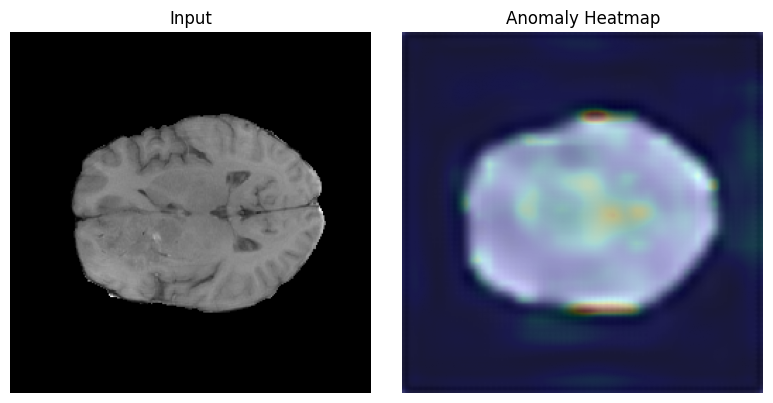

In [ ]:
import matplotlib.pyplot as plt

def anomaly_map(enc_feats, dec_feats, input_size=(256,256)):
    # Align decoder→encoder stages
    dec_feats = dec_feats[::-1]
    total_map = None
    for fe, fd in zip(enc_feats, dec_feats):
        # cosine-distance map at feature resolution
        cos_map = 1 - F.cosine_similarity(fd, fe, dim=1).unsqueeze(1)  # (B,1,h,w)
        up = F.interpolate(cos_map, size=input_size, mode='bilinear', align_corners=False)
        total_map = up if total_map is None else total_map + up
    return total_map  # (B,1,H,W)

# Move model & data to GPU
model.to(device).eval()

# Grab one image
img = test_ds[0][0].unsqueeze(0).to(device)
with torch.no_grad():
    recon, enc_feats, dec_feats = model(img)
    amap = anomaly_map(enc_feats, dec_feats)[0,0].cpu().numpy()

input_size = (256,256)
orig = img[0,0].cpu().numpy()
recon = F.interpolate(recon, size=input_size, mode='bilinear', align_corners=False)

# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig, cmap='gray'); plt.title('Input'); plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon[0,0].cpu().numpy(), cmap='gray')
plt.imshow(amap, cmap='jet', alpha=0.2)
plt.title('Anomaly Heatmap'); plt.axis('off')

plt.tight_layout()
plt.show()

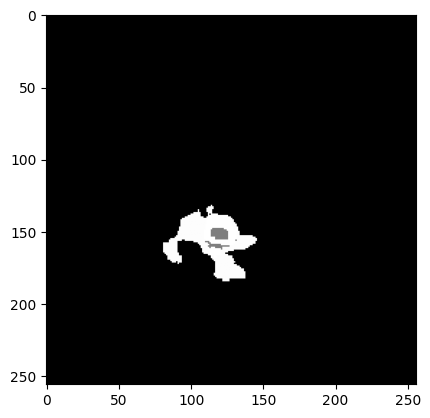

In [ ]:
test_ms = PNGSliceDataset(
    '/content/drive/MyDrive/CV_Proj_Anomaly_AE/brats_slices/masks', transform=transform2)
plt.imshow(test_ms[200][0][0].numpy(), cmap="gray")

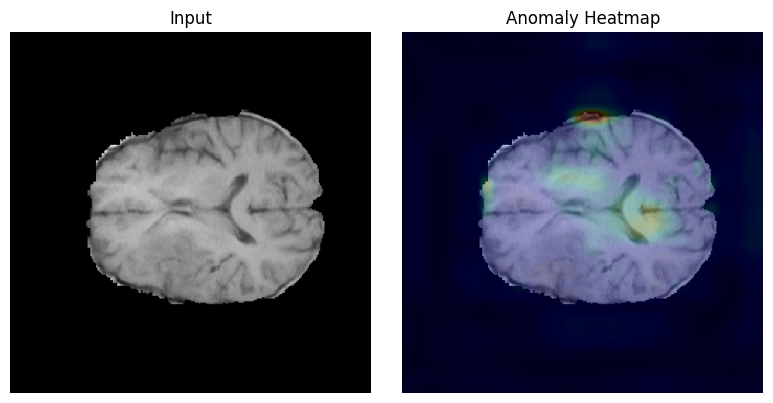

In [ ]:
import matplotlib.pyplot as plt

def anomaly_map(enc_feats, dec_feats, input_size=(256,256)):
    # Align decoder→encoder stages
    dec_feats = dec_feats[::-1]
    total_map = None
    for fe, fd in zip(enc_feats, dec_feats):
        # cosine-distance map at feature resolution
        cos_map = 1 - F.cosine_similarity(fd, fe, dim=1).unsqueeze(1)  # (B,1,h,w)
        up = F.interpolate(cos_map, size=input_size, mode='bilinear', align_corners=False)
        total_map = up if total_map is None else total_map + up
    return total_map  # (B,1,H,W)

# Move model & data to GPU
model.to(device).eval()

# Grab one image
img = test_ds[200][0].unsqueeze(0).to(device)
with torch.no_grad():
    recon, enc_feats, dec_feats = model(img)
    amap = anomaly_map(enc_feats, dec_feats)[0,0].cpu().numpy()

# Prepare image for plotting
orig = img[0,0].cpu().numpy()  # one channel

# Plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig, cmap='gray'); plt.title('Input'); plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(orig, cmap='gray')
plt.imshow(amap, cmap='jet', alpha=0.2)
plt.title('Anomaly Heatmap'); plt.axis('off')

plt.tight_layout()
plt.show()